In [ ]:
!pip install fastf1 scikit-learn pandas numpy --quiet
import os
import fastf1

os.makedirs("/content/f1_cache", exist_ok=True)

fastf1.Cache.enable_cache("/content/f1_cache")
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [ ]:
session_2024 = fastf1.get_session(2024, "Saudi Arabia", "R")
session_2024.load()

laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

In [ ]:
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)


In [ ]:
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "PIA", "LEC", "RUS", "HAM", "GAS", "ALO", "TSU", "SAI", "HUL", "OCO", "STR", "NOR"],
    "QualifyingTime (s)": [87.294, 87.304, 87.670, 87.407, 88.201, 88.367, 88.303, 88.204, 88.164, 88.782, 89.092, 88.645, 87.489]
})


In [ ]:
driver_wet_performance = {
    "VER": 0.975196, "HAM": 0.976464, "LEC": 0.975862, "NOR": 0.978179, "ALO": 0.972655,
    "RUS": 0.968678, "SAI": 0.978754, "TSU": 0.996338, "OCO": 0.981810, "GAS": 0.978832, "STR": 0.979857
}
qualifying_2025["WetPerformanceFactor"] = qualifying_2025["Driver"].map(driver_wet_performance)


In [ ]:
API_KEY = "4e078bd52791a7bbc6b52a90051e12f7"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=21.4225&lon=39.1818&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-04-20 18:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20


In [ ]:
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [ ]:
average_2025 = {
    "VER": 88.0, "PIA": 89.1, "LEC": 89.2, "RUS": 89.3, "HAM": 89.4,
    "GAS": 89.5, "ALO": 89.6, "TSU": 89.7, "SAI": 89.8, "HUL": 89.9,
    "OCO": 90.0, "STR": 90.1, "NOR": 90.2
}

team_points = {
    "McLaren": 78, "Mercedes": 53, "Red Bull": 36, "Williams": 17, "Ferrari": 17,
    "Haas": 14, "Aston Martin": 10, "Kick Sauber": 6, "Racing Bulls": 3, "Alpine": 0
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)
qualifying_2025["Average2025Performance"] = qualifying_2025["Driver"].map(average_2025)


In [ ]:
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["LastYearWinner"] = (merged_data["Driver"] == "VER").astype(int)
merged_data["QualifyingTime"] = merged_data["QualifyingTime"] ** 2


In [ ]:
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])
clean_data = merged_data.copy()
clean_data["LapTime (s)"] = y.values
clean_data = clean_data.dropna(subset=["LapTime (s)"])

X = clean_data[[
    "QualifyingTime", "TeamPerformanceScore", "RainProbability", "Temperature", "TotalSectorTime (s)", "Average2025Performance"
]]
y = clean_data["LapTime (s)"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=39)
model.fit(X_train, y_train)

clean_data["PredictedRaceTime (s)"] = model.predict(X)
final_results = clean_data.sort_values("PredictedRaceTime (s)")


In [ ]:
print("Predicted 2025 Saudi Arabian GP Winner:")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


Predicted 2025 Saudi Arabian GP Winner:
   Driver  PredictedRaceTime (s)
0     VER              93.567873
1     PIA              94.239782
6     ALO              94.473724
2     LEC              94.551538
3     RUS              94.631787
12    NOR              94.750192
4     HAM              94.828553
11    STR              95.794750
9     HUL              96.816954
10    OCO              97.159957
7     TSU              97.164106
Model Error (MAE): 0.62 seconds


In [ ]:
clean_data["Residual"] = clean_data["LapTime (s)"] - clean_data["PredictedRaceTime (s)"]
driver_errors = clean_data.groupby("Driver")["Residual"].mean().sort_values()
print(driver_errors)


Driver
HUL   -1.222188e+00
LEC   -5.052184e-01
VER   -3.587152e-07
ALO   -1.707236e-07
RUS   -1.379206e-07
NOR   -1.195123e-07
HAM   -9.092155e-08
STR    1.034295e-07
OCO    3.723547e-07
TSU    4.020091e-07
PIA    1.390267e-01
Name: Residual, dtype: float64


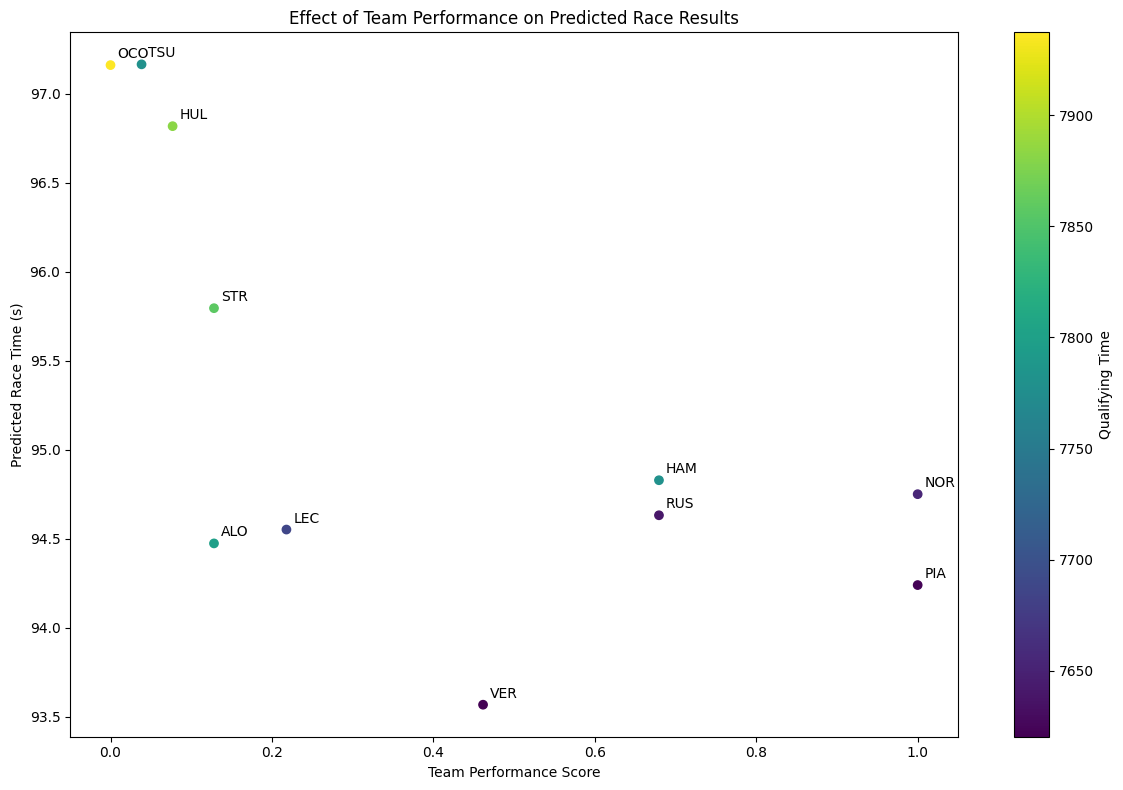

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(final_results["TeamPerformanceScore"],
            final_results["PredictedRaceTime (s)"],
            c=final_results["QualifyingTime"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["TeamPerformanceScore"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')

plt.colorbar(label="Qualifying Time")
plt.xlabel("Team Performance Score")
plt.ylabel("Predicted Race Time (s)")
plt.title("Effect of Team Performance on Predicted Race Results")
plt.tight_layout()
plt.savefig('team_performance_effect.png')
plt.show()


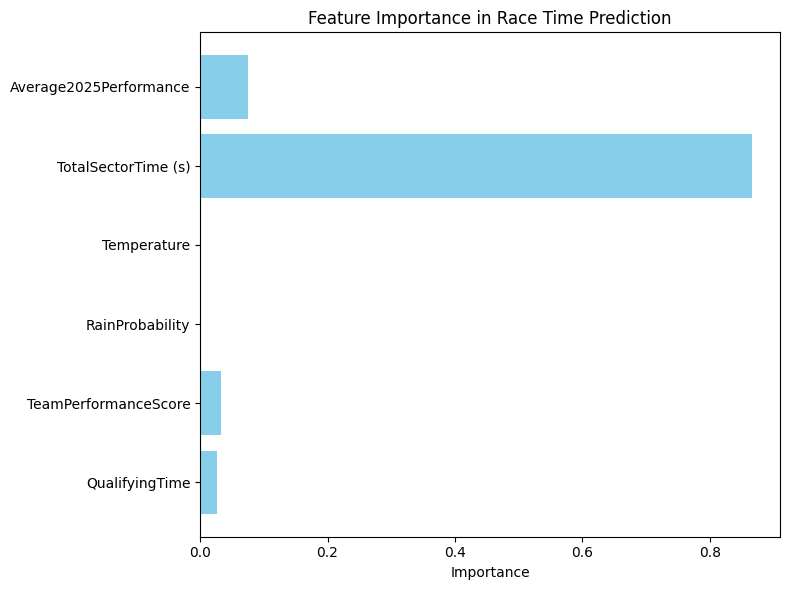

In [ ]:
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()
corr_matrix = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "LastYearWinner", "Average2025Performance", "TotalSectorTime (s)"
]].copy()
